In [1]:
import struct
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def parse_ideal_line(path):
    with open(path, "rb") as f:
        version = struct.unpack("<i", f.read(4))[0]
        if version != 7:
            raise ValueError(f"Unsupported spline version: {version}")

        point_count = struct.unpack("<i", f.read(4))[0]
        lap_time = struct.unpack("<i", f.read(4))[0]
        sample_count = struct.unpack("<i", f.read(4))[0]

        # AiPoint: position (vec3), length, id
        points = []
        for _ in range(point_count):
            x, y, z = struct.unpack("<fff", f.read(12))
            length = struct.unpack("<f", f.read(4))[0]
            point_id = struct.unpack("<i", f.read(4))[0]
            points.append([x, y, z, length, point_id])

        extra_count = struct.unpack("<i", f.read(4))[0]
        if extra_count != point_count:
            raise ValueError("Mismatch between point count and extra data count.")

        # AiPointExtra: 18 floats = 72 bytes
        extras = []
        for _ in range(extra_count):
            data = struct.unpack("<" + "f" * 18, f.read(72))
            extras.append(list(data))

    columns = [
        "x", "y", "z", "length", "id",
        "speed", "gas", "brake", "obsolete_lat_g", "radius",
        "side_left", "side_right", "camber", "direction",
        "normal_x", "normal_y", "normal_z",
        "extra_length",
        "forward_x", "forward_y", "forward_z",
        "tag", "grade"
    ]

    df = pd.DataFrame([p + e for p, e in zip(points, extras)], columns=columns)
    return df

In [3]:
def plot_racing_line_with_map(
    df,
    map_image_path,
    offset=(0, 0),
    scale=1.0,
    color_by="speed",
    title="Racing Line + Map"
):
    # Load map image
    img = Image.open(map_image_path)
    w, h = img.size

    # Create plot
    fig, ax = plt.subplots(figsize=(16, 16), dpi=100)

    # Display image using scaled extent
    extent = [
        offset[0], offset[0] + w * scale,
        offset[1] + h * scale, offset[1]
    ]
    ax.imshow(img, extent=extent, origin="upper", alpha=0.6)

    # Plot racing line
    x = df["x"]
    z = df["z"]

    if color_by in df.columns:
        sc = ax.scatter(x, z, c=df[color_by], cmap="viridis", s=0.25)
        cbar = plt.colorbar(sc, ax=ax)
        cbar.set_label(color_by)
    else:
        ax.plot(x, z, lw=1)

    ax.set_title(f"Racing Line: {title}")
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_aspect("equal")
    plt.grid(True)
    plt.show()


In [4]:
map = "../data/assetto_corsa_tracks/ks_nurburgring/"
versions = {"gp_a":("layout_gp_a/data/ideal_line.ai", "layout_gp_a/map.png"), "gp_b":("layout_gp_b/data/ideal_line.ai", "layout_gp_b/map.png"),
            "sprint_a":("layout_sprint_a/data/ideal_line.ai", "layout_sprint_a/map.png"), "sprint_b": ("layout_sprint_b/data/ideal_line.ai", "layout_sprint_b/map.png")}

name = "sprint_a" # gp_a, gp_b, sprint_a, sprint_b
data_path = map + versions[name][0] 
image_path = map + versions[name][1]
racing_line = parse_ideal_line(data_path)

In [5]:
racing_line.info()
racing_line.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   x               2263 non-null   float64
 1   y               2263 non-null   float64
 2   z               2263 non-null   float64
 3   length          2263 non-null   float64
 4   id              2263 non-null   int64  
 5   speed           2263 non-null   float64
 6   gas             2263 non-null   float64
 7   brake           2263 non-null   float64
 8   obsolete_lat_g  2263 non-null   float64
 9   radius          2263 non-null   float64
 10  side_left       2263 non-null   float64
 11  side_right      2263 non-null   float64
 12  camber          2263 non-null   float64
 13  direction       2263 non-null   float64
 14  normal_x        2263 non-null   float64
 15  normal_y        2263 non-null   float64
 16  normal_z        2263 non-null   float64
 17  extra_length    2263 non-null   f

,x,y,z,length,id,speed,gas,brake,obsolete_lat_g,radius,...,direction,normal_x,normal_y,normal_z,extra_length,forward_x,forward_y,forward_z,tag,grade
0,-5.072040,63.957699,-763.414062,0.000000,0,53.244282,1.0,0.0,0.053762,95587.492188,...,1.0,-0.019014,0.999810,0.004393,7.729438,0.0,0.0,0.0,0.0,-0.005045
1,-5.053395,63.949585,-761.804810,1.609391,1,53.384312,1.0,0.0,0.048723,104883.968750,...,1.0,-0.018530,0.999805,0.006871,7.694904,0.0,0.0,0.0,0.0,-0.005033
2,-5.033705,63.941536,-760.219604,3.194740,2,53.524338,1.0,0.0,0.043683,114180.445312,...,1.0,-0.018819,0.999808,0.005438,7.660370,0.0,0.0,0.0,0.0,-0.005036
3,-5.013196,63.933590,-758.663879,4.750626,3,53.664368,1.0,0.0,0.038644,123476.921875,...,1.0,-0.019383,0.999796,0.005662,7.625837,0.0,0.0,0.0,0.0,-0.005048
4,-4.992064,63.925751,-757.138977,6.275701,4,53.804398,1.0,0.0,0.033604,132773.390625,...,1.0,-0.019232,0.999806,0.004259,7.591303,0.0,0.0,0.0,0.0,-0.005053


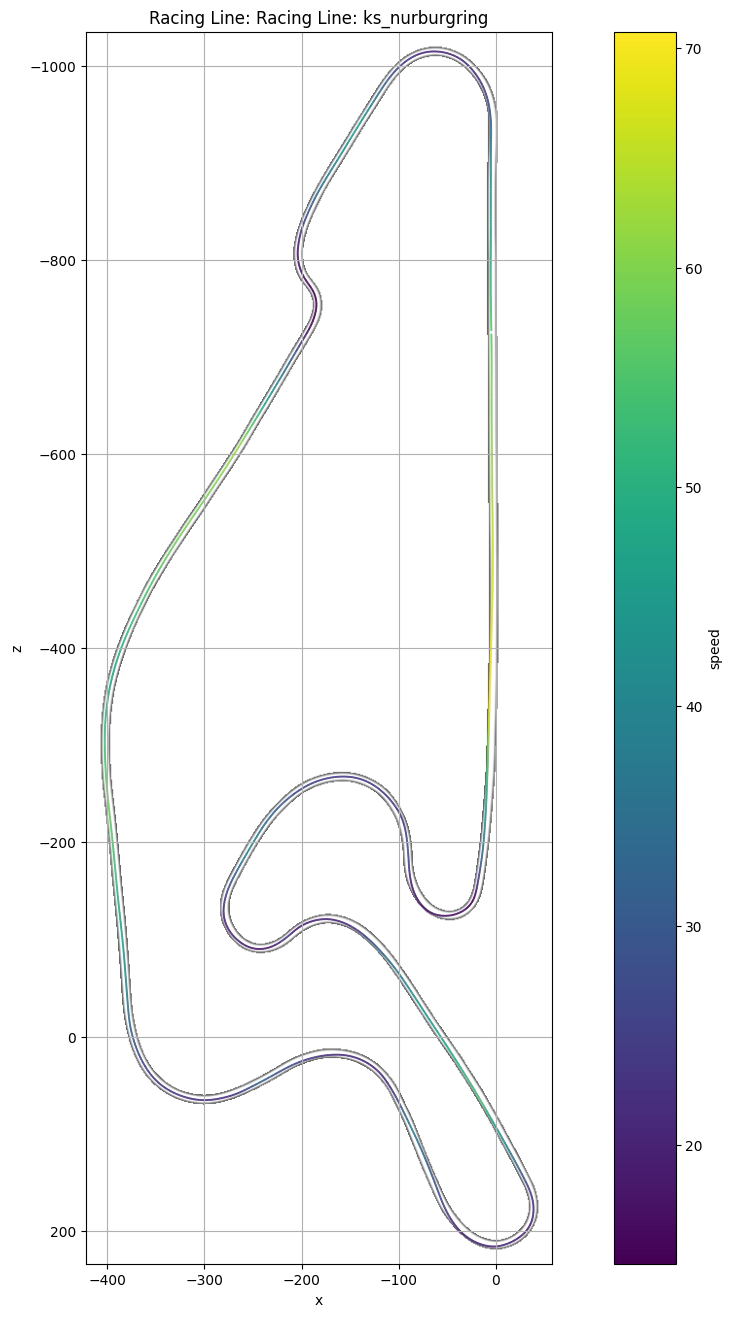

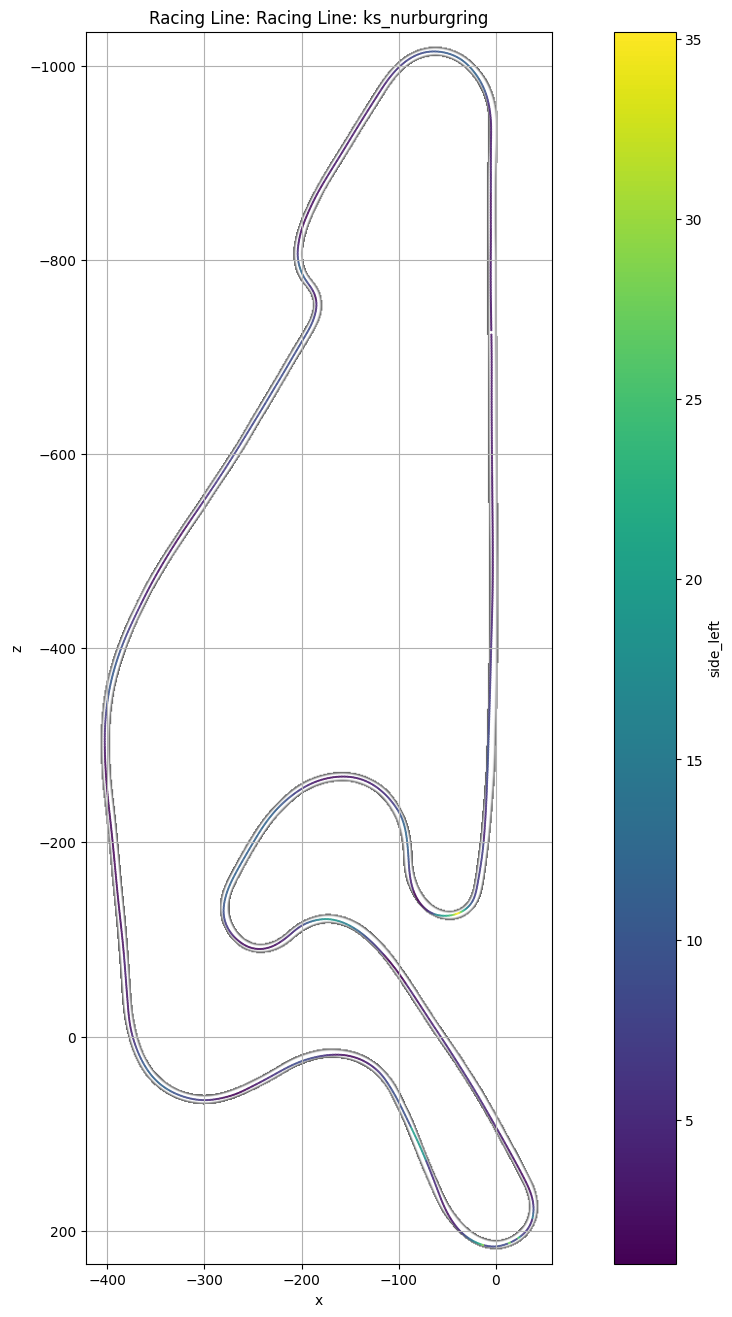

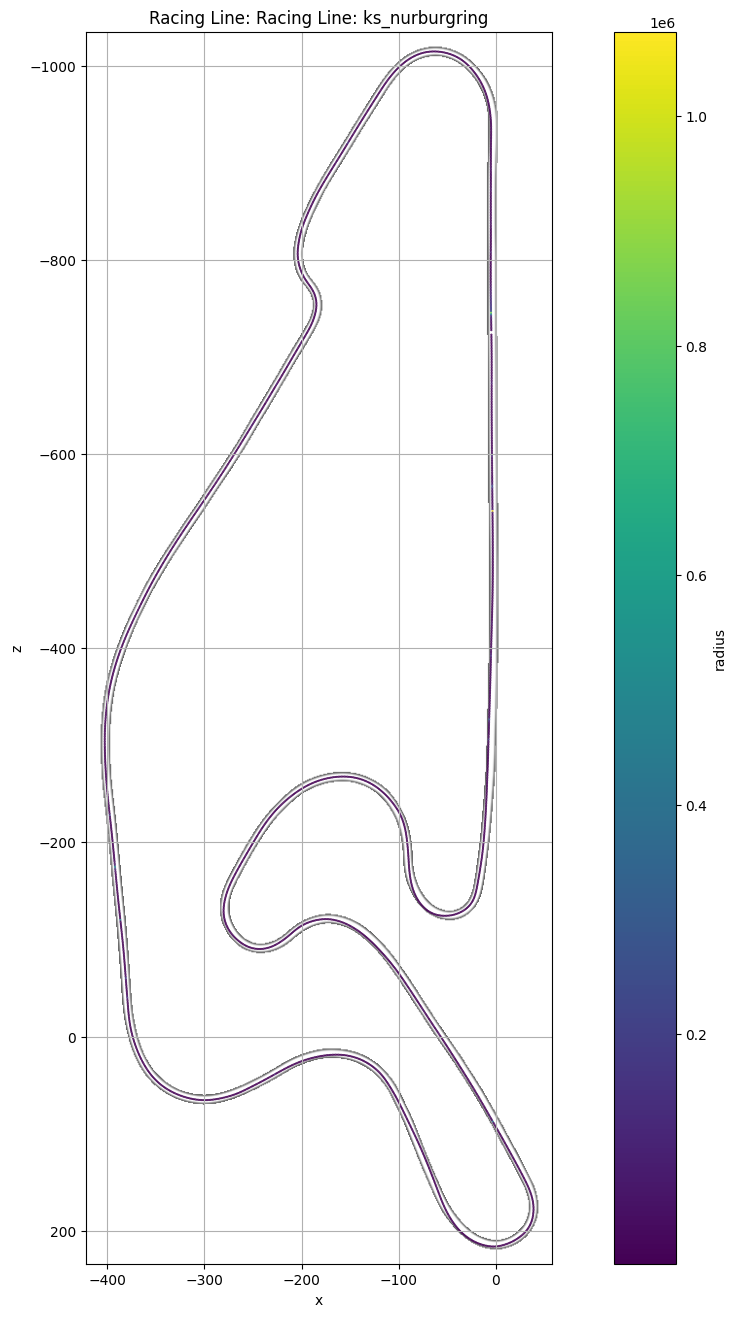

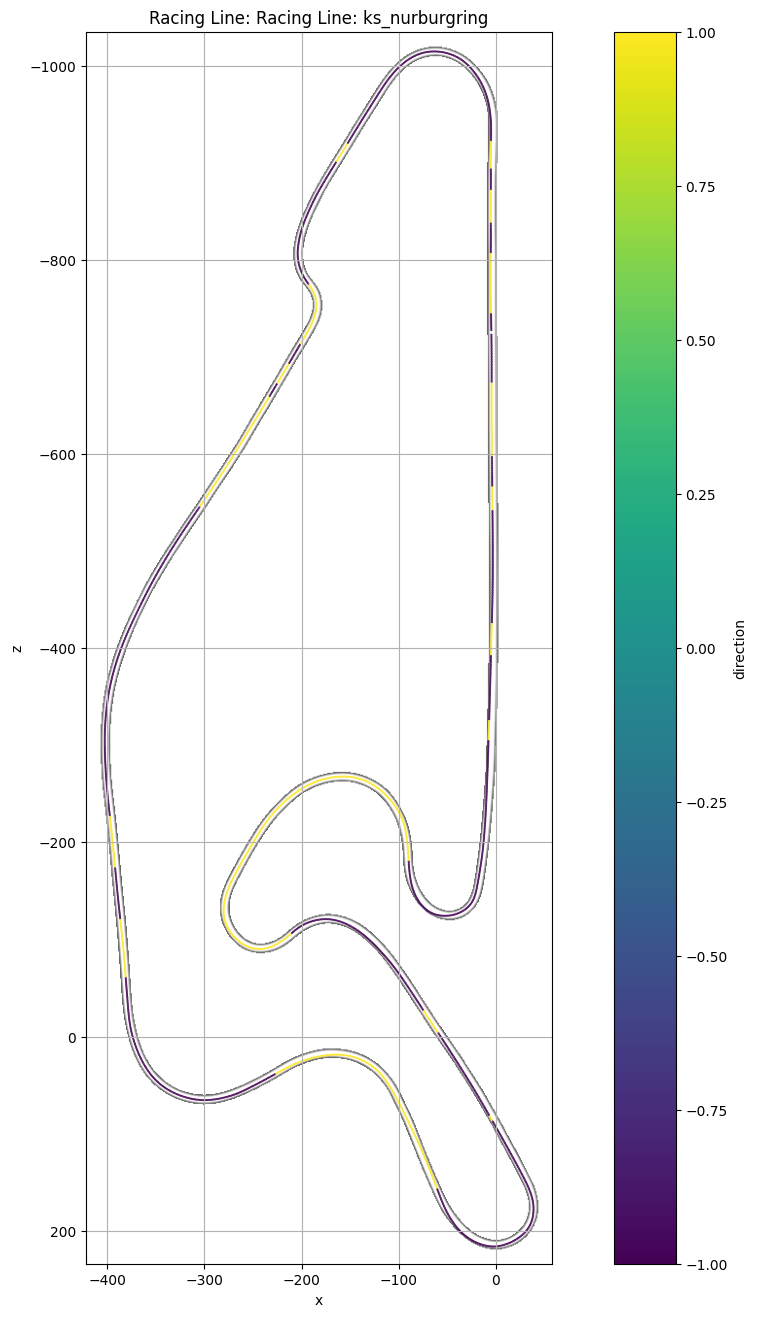

In [6]:
# Offsets might not align perfectly however its close enough to visually see this code is producing what we desire
# GP Plot Vars 
# scl = 1.2
# off = (-422, -1035)

# Sprint Plot Vars 
scl = 1
off = (-422, -1035)

# Plot 
plot_racing_line_with_map(racing_line, map_image_path=image_path, color_by="speed", title="Racing Line: ks_nurburgring", offset=off, scale=scl)
plot_racing_line_with_map(racing_line, map_image_path=image_path, color_by="side_left", title="Racing Line: ks_nurburgring", offset=off, scale=scl)
plot_racing_line_with_map(racing_line, map_image_path=image_path, color_by="radius", title="Racing Line: ks_nurburgring", offset=off, scale=scl)
plot_racing_line_with_map(racing_line, map_image_path=image_path, color_by="direction", title="Racing Line: ks_nurburgring", offset=off, scale=scl)